<a href="https://colab.research.google.com/github/JorgeZarama/Supervisado/blob/main/Programa15_Clasificacion_LOGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sklearn.metrics as metrics
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn import preprocessing
from evaluacion_funciones import *

In [13]:
# Carga de datos.
datos = load_iris()
X = datos.data
y = datos.target
print(np.shape(X))

(150, 4)


In [14]:
# Métricas de evaluación.
metricas = {
  'ACC':    metrics.accuracy_score,
  'PREC':   lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred, average='micro'),
  'RECALL': lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred, average='micro'),
  'F1':     lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')}

In [15]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))

(120, 4)


In [16]:
# ------------- TRAINING ---------------- #

In [17]:
# 2) Extracción de características

In [18]:
# 3) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
X_stdr = standardizer.fit_transform(X_training)
# print(X_stdr)

In [19]:
# 4) Selección de atributos
selector = SelectPercentile(score_func=mutual_info_classif, percentile=90)
X_stdr = selector.fit_transform(X_stdr, y_training)
print(np.shape(X_stdr))

(120, 3)


In [20]:
# 5) Construcción del algoritmo de aprendizaje.
algoritmos = {'LOGR': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42, multi_class='ovr')}

In [21]:
# 5.1) Validación cruzada interna y Optimización de los hiperparámetros
y_pred = {}
for nombre, alg in algoritmos.items():
    y_pred[nombre] = cross_val_predict(alg, X_stdr, y_training, cv=KFold(n_splits=10, shuffle=True, random_state=42))
    results = evaluacion(y_training, y_pred[nombre], metricas)
    print(metrics.confusion_matrix(y_training, y_pred[nombre]))
    print(results)

#     results = cross_val_score(alg, X_stdr, y_training, cv = KFold(n_splits=10, shuffle=True, random_state=42))
#     print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))

[[40  0  0]
 [ 1 37  3]
 [ 0  4 35]]
{'ACC': 0.9333333333333333, 'PREC': 0.9333333333333333, 'RECALL': 0.9333333333333333, 'F1': 0.9333333333333333}


In [22]:
# 5.2) Entrenamiento del modelo definitivo
model = algoritmos['LOGR'].fit(X_stdr, y_training)

# Visualización de las fronteras de decisión
# mapa_modelo_clasif_2d(X_stdr, y_training, model, results, nombre)

In [23]:
# ------------- PREDICTION ---------------- #

In [24]:
# 6) Extracción de las características de test

In [25]:
# 7) Estandarización de las característiacs de test
X_test_stdr = standardizer.transform(X_testing)

In [26]:
# 8) Selección de los atributos de test
X_test_stdr = selector.transform(X_test_stdr)

In [27]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)
print(y_pred_test)

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]


In [28]:
# 10) Evaluación del modelo sobre el conjunto de test
results = evaluacion(y_testing, y_pred_test, metricas)
print(results)
print(metrics.confusion_matrix(y_testing, y_pred_test))

{'ACC': 1.0, 'PREC': 1.0, 'RECALL': 1.0, 'F1': 1.0}
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


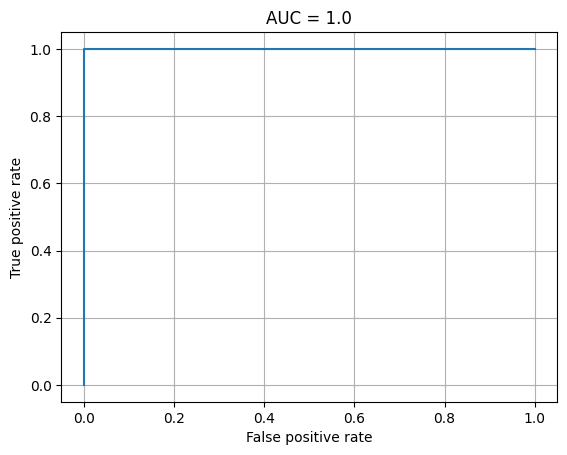

In [29]:
# Ploteamos la curva ROC
y_proba_test = model.predict_proba(X_test_stdr) # "predict_proba" para extraer probabilidades en vez de predicciones
# print(y_proba_test)

y_test_bin = preprocessing.label_binarize(y_testing, classes=[0,1,2]) # Usar "label_binarize" en el caso de problemas multiclase

auc = metrics.roc_auc_score(y_testing, y_proba_test, multi_class='ovr') # Area Under the ROC curve (AUC)

fpr, tpr, th = metrics.roc_curve(y_test_bin[:,1], y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()